In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# from dtreeviz.trees import dtreeviz

from openTSNE import TSNE

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('samo_jedinstvene_kodirajuce_sekvence.csv', header=None, on_bad_lines='warn')

In [3]:
df.shape

(889737, 15)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,BCA87360.1,LC528232.2,join,249,13451,13451,21538,2020-02-29-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,21291,21291,ORF1ab polyprotein,20200210,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...
1,BCA87379.1,LC528233.2,raw,29551,29667,0,0,2020-02-29-00.00.00.000000,B.5,4.1.2/1.12/v0.1.10/0.3.17,117,117,ORF10 protein,20200210,ATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTC...
2,BCB15089.1,LC529905.1,join,266,13468,13468,21555,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,21291,21291,ORF1ab polyprotein,20200115,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...
3,BCB15091.1,LC529905.1,raw,25393,26220,0,0,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,828,828,ORF3a protein,20200115,ATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGA...
4,BCB15098.1,LC529905.1,raw,28274,29533,0,0,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,1260,1260,nucleocapsid phosphoprotein,20200115,ATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTA...


In [5]:
length = np.array([len(a) for a in df[14]])
valid = (length > 8) & (length % 3 == 0)

df = df[valid]
df.shape

(889695, 15)

In [6]:
valid = np.full(df.shape[0], True)

for n, seq in enumerate(df[14]):
    for atcg in seq:
        if atcg not in ('A', 'T', 'C', 'G'):
            valid[n] = False
            break

In [7]:
df = df[valid]
df.shape

(869874, 15)

In [8]:
proteins = df.groupby([12])[12].count()
proteins.name = 'protein type counts'

In [9]:
print(proteins.sort_values(ascending=False))

12
ORF1ab polyprotein               393049
ORF1a polyprotein                301715
surface glycoprotein              95978
nucleocapsid phosphoprotein       36379
ORF3a protein                     23095
membrane glycoprotein              6354
ORF7a protein                      4921
ORF8 protein                       4789
ORF6 protein                       1372
ORF7b protein                       929
envelope protein                    822
ORF10 protein                       455
nsp2                                  1
nsp9                                  1
nsp8                                  1
nsp7                                  1
nsp6                                  1
nsp4                                  1
nsp3                                  1
2'-O-ribose methyltransferase         1
nsp11                                 1
nsp10                                 1
leader protein                        1
3'-to-5' exonuclease                  1
endoRNAse                            

In [10]:
counts = np.array([proteins[a] for a in df[12]])

In [11]:
df = df[counts > 448]
df.shape

(869858, 15)

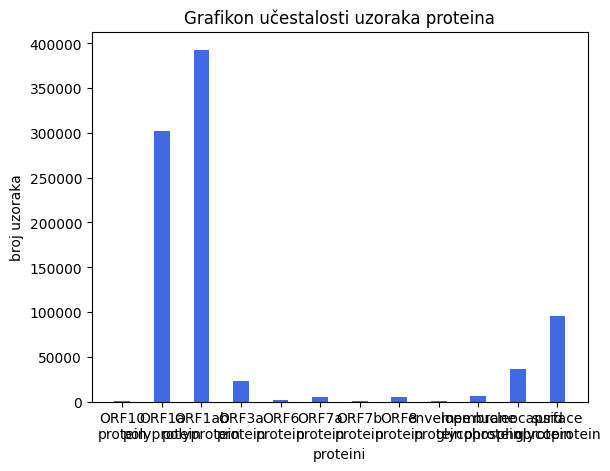

In [12]:
proteins = df.groupby([12])[12].count()

_ = plt.bar([a.replace(' ', '\n') for a in proteins.index], proteins[:], color='royalblue', width=0.4)

plt.xlabel('proteini')
plt.ylabel('broj uzoraka')
plt.title('Grafikon učestalosti uzoraka proteina')

plt.show()

In [13]:
df = df[[14, 12]]

In [14]:
standard_codon_table = {
    'TTT': 'F', 'TCT': 'S', 'TAT': 'Y', 'TGT': 'C',
    'TTC': 'F', 'TCC': 'S', 'TAC': 'Y', 'TGC': 'C',
    'TTA': 'L', 'TCA': 'S', 'TAA': 'O', 'TGA': 'O',
    'TTG': 'L', 'TCG': 'S', 'TAG': 'O', 'TGG': 'W',

    'CTT': 'L', 'CCT': 'P', 'CAT': 'H', 'CGT': 'R',
    'CTC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',
    'CTA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R',
    'CTG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',

    'ATT': 'I', 'ACT': 'T', 'AAT': 'N', 'AGT': 'S',
    'ATC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',
    'ATA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R',
    'ATG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',

    'GTT': 'V', 'GCT': 'A', 'GAT': 'D', 'GGT': 'G',
    'GTC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',
    'GTA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G',
    'GTG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G'
}

In [15]:
inverse_codon_table = {
    'F': ('TTT', 'TTC'),
    'L': ('CTT', 'CTC', 'CTA', 'CTG', 'TTA', 'TTG'),
    'I': ('ATT', 'ATC', 'ATA'),
    'M': ('ATG', ),
    'V': ('GTT', 'GTC', 'GTA', 'GTG'),
    'S': ('TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'),
    'P': ('CCT', 'CCC', 'CCA', 'CCG'),
    'T': ('ACT', 'ACC', 'ACA', 'ACG'),
    'A': ('GCT', 'GCC', 'GCA', 'GCG'),
    'Y': ('TAT', 'TAC'),
    'O': ('TAA', 'TGA', 'TAG'),
    'H': ('CAT', 'CAC'),
    'Q': ('CAA', 'CAG'),
    'N': ('AAT', 'AAC'),
    'K': ('AAA', 'AAG'),
    'D': ('GAT', 'GAC'),
    'E': ('GAA', 'GAG'),
    'C': ('TGT', 'TGC'),
    'W': ('TGG', ),
    'R': ('CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'),
    'G': ('GGT', 'GGC', 'GGA', 'GGG')
}

In [16]:
length = df.shape[0]

codon_counts = {a: np.zeros(length) for a in standard_codon_table.keys()}

for n, seq in enumerate(df[14]):
    for i in range(0, len(seq) - 2, 3):
        codon = seq[i:i+3]
        codon_counts[codon][n] += 1

In [17]:
length = df.shape[0]

amino_counts = {a: np.zeros(length) for a in inverse_codon_table.keys()}

for amino, codons in inverse_codon_table.items():
    for codon in codons:
        amino_counts[amino] += codon_counts[codon]

In [18]:
for codon in standard_codon_table.keys():
    codon_counts[codon] /= amino_counts[standard_codon_table[codon]]
    np.nan_to_num(codon_counts[codon], copy=False, nan=0, posinf=0, neginf=0)

C:\Users\CTHULU\AppData\Local\Temp\ipykernel_13648\3205468521.py:2: RuntimeWarning: invalid value encountered in divide
  codon_counts[codon] /= amino_counts[standard_codon_table[codon]]


In [19]:
X = pd.DataFrame.from_dict(codon_counts)
X.drop(['TAA', 'TGA', 'TAG'], axis=1, inplace=True)
X.describe()

,TTT,TCT,TAT,TGT,TTC,TCC,TAC,TGC,TTA,TCA,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
count,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,...,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000,869858.000000
mean,0.715979,0.329285,0.597153,0.765892,0.284020,0.074737,0.402823,0.201758,0.269884,0.279328,...,0.362941,0.171330,0.212883,0.275372,0.729588,0.190976,0.150061,0.037577,0.269887,0.027213
std,0.108142,0.048415,0.105980,0.163928,0.108139,0.028977,0.105958,0.092857,0.060716,0.031920,...,0.056536,0.058916,0.042423,0.043582,0.050212,0.041933,0.030618,0.020200,0.047747,0.016677
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.730659,0.333333,0.574359,0.814159,0.244019,0.059341,0.377976,0.181159,0.267898,0.277293,...,0.352185,0.153285,0.207547,0.268608,0.726471,0.167300,0.146667,0.032854,0.263598,0.022814
50%,0.733524,0.337004,0.620896,0.814978,0.266476,0.068259,0.379104,0.185022,0.270642,0.279863,...,0.354756,0.159091,0.212938,0.268994,0.729412,0.184915,0.148581,0.034979,0.270588,0.024331
75%,0.755981,0.338496,0.622024,0.818841,0.269341,0.071918,0.425641,0.185841,0.300595,0.281319,...,0.367925,0.160305,0.229097,0.269547,0.736402,0.185366,0.153639,0.042071,0.273529,0.024390
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.777778,1.000000,...,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
X.head()

,TTT,TCT,TAT,TGT,TTC,TCC,TAC,TGC,TTA,TCA,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
0,0.728571,0.337719,0.620896,0.814159,0.271429,0.059211,0.379104,0.185841,0.301349,0.280702,...,0.354756,0.152913,0.229097,0.268994,0.729412,0.184466,0.147157,0.032854,0.270588,0.024272
1,0.750000,0.500000,1.000000,0.000000,0.250000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.727794,0.337719,0.620896,0.814159,0.272206,0.059211,0.379104,0.185841,0.300898,0.280702,...,0.354756,0.152913,0.229097,0.268994,0.729412,0.184466,0.147157,0.032854,0.270588,0.024272
3,0.571429,0.136364,0.470588,0.428571,0.428571,0.181818,0.529412,0.571429,0.103448,0.363636,...,0.461538,0.214286,0.269231,0.230769,0.909091,0.285714,0.038462,0.000000,0.090909,0.000000
4,0.230769,0.210526,0.181818,0.000000,0.769231,0.078947,0.818182,0.000000,0.074074,0.263158,...,0.416667,0.372093,0.125000,0.216216,0.666667,0.302326,0.250000,0.081081,0.333333,0.093023


In [21]:
y = df[12]
y.describe()

count                 869858
unique                    12
top       ORF1ab polyprotein
freq                  393049
Name: 12, dtype: object

In [22]:
y.head()

0             ORF1ab polyprotein
1                  ORF10 protein
2             ORF1ab polyprotein
3                  ORF3a protein
4    nucleocapsid phosphoprotein
Name: 12, dtype: object

In [23]:
enc = LabelEncoder()
_ = enc.fit(proteins.index.to_numpy())

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=196883, stratify=y)

In [25]:
corr_matrix = X_train.corr()
corr_matrix.shape

,TTT,TCT,TAT,TGT,TTC,TCC,TAC,TGC,TTA,TCA,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,-0.069126,-0.053277,-0.058398,-0.032955,0.069203,0.037910,0.058928,-0.029381,-0.061038,-0.045134,...,0.049245,0.051513,0.001978,-0.027006,0.013680,0.071865,0.055288,0.018225,-0.003874,0.054490
std,0.517667,0.439740,0.457357,0.400790,0.517660,0.341645,0.457233,0.356111,0.458357,0.287503,...,0.363061,0.433799,0.360358,0.341657,0.345196,0.394592,0.420352,0.328408,0.361778,0.454033
min,-0.999939,-0.704406,-0.998721,-0.669007,-0.999939,-0.648761,-0.998721,-0.778584,-0.824122,-0.491368,...,-0.992374,-0.805712,-0.679359,-0.676361,-0.891560,-0.683546,-0.787599,-0.596898,-0.891560,-0.697188
25%,-0.537182,-0.367927,-0.400568,-0.347661,-0.230297,-0.194563,-0.186242,-0.300396,-0.424827,-0.249856,...,-0.207390,-0.288790,-0.222819,-0.278546,-0.314882,-0.195155,-0.307848,-0.234285,-0.325523,-0.322903
50%,-0.019928,-0.092790,-0.005880,-0.110086,0.020003,0.009493,0.005881,-0.048551,-0.082584,-0.078249,...,0.038078,0.062943,0.006123,-0.050282,0.064566,0.081575,0.061563,-0.049722,-0.025883,0.015256
75%,0.230320,0.313929,0.188051,0.302012,0.537261,0.260274,0.400453,0.216082,0.244894,0.073144,...,0.312044,0.364267,0.218066,0.185367,0.285544,0.363016,0.406007,0.257249,0.326255,0.428347
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


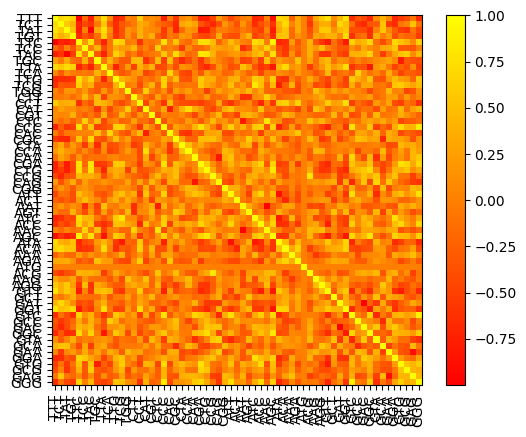

In [27]:
plt.imshow(corr_matrix, cmap='autumn')
plt.colorbar()

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.show()

In [28]:
tsne = TSNE(n_components=2,
            perplexity=50,
            exaggeration=4,
            n_iter=10000,
            early_exaggeration_iter=1000,
            n_jobs=-1, metric='manhattan',
            learning_rate='auto',
            initialization='random',
            random_state=196883)

X_train_tsne = tsne.fit(X_train.to_numpy())

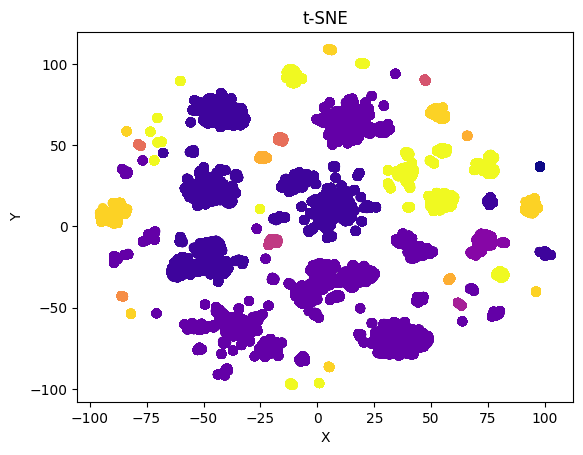

In [29]:
_ = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=enc.transform(y_train), cmap='plasma')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('t-SNE')

plt.show()

In [30]:
clf = ComplementNB()
_ = clf.fit(X_train, y_train)

In [31]:
print('izvestaj za trening skup')

y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       0.00      0.00      0.00       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       0.94      1.00      0.97     18476
               ORF6 protein       0.00      0.00      0.00      1098
              ORF7a protein       1.00      0.87      0.93      3937
              ORF7b protein       0.00      0.00      0.00       743
               ORF8 protein       1.00      0.61      0.76      3831
           envelope protein       0.00      0.00      0.00       658
      membrane glycoprotein       0.00      0.00      0.00      5083
nucleocapsid phosphoprotein       0.83      1.00      0.91     29103
       surface glycoprotein       0.99      1.00      0.99     76782

                   accuracy                           0.99    695886
       

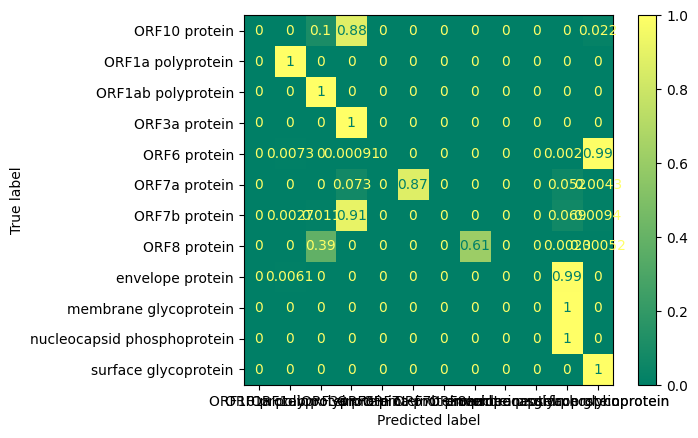

In [32]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

In [33]:
print('izvestaj za test skup')

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       0.00      0.00      0.00        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       0.99      1.00      1.00     78610
              ORF3a protein       0.93      1.00      0.97      4619
               ORF6 protein       0.00      0.00      0.00       274
              ORF7a protein       1.00      0.87      0.93       984
              ORF7b protein       0.00      0.00      0.00       186
               ORF8 protein       1.00      0.59      0.74       958
           envelope protein       0.00      0.00      0.00       164
      membrane glycoprotein       0.00      0.00      0.00      1271
nucleocapsid phosphoprotein       0.83      1.00      0.91      7276
       surface glycoprotein       0.99      1.00      0.99     19196

                   accuracy                           0.99    173972
          

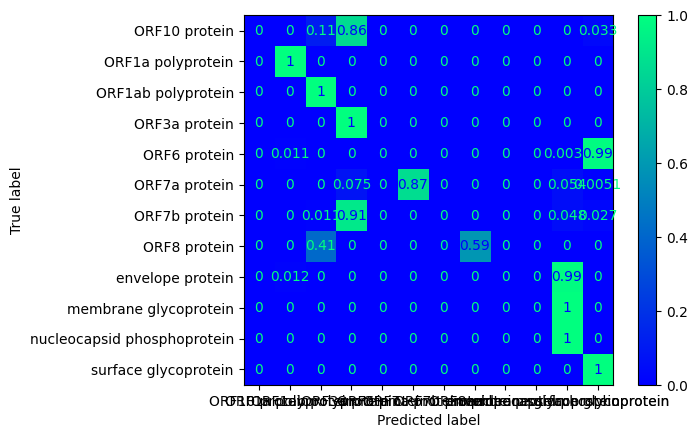

In [34]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()

In [35]:
params = [{'estimator': [ComplementNB()],
           'n_estimators': [128, 512, 1024],
           'max_samples': [0.4, 0.6],
           'max_features': [0.4, 0.6],
           'n_jobs': [-1],
           'random_state': [196883]}]

In [36]:
clf = GridSearchCV(BaggingClassifier(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train, y_train)

In [37]:
clf.best_score_

0.5531258349270537

In [38]:
clf.best_params_

{'estimator': ComplementNB(),
 'max_features': 0.4,
 'max_samples': 0.4,
 'n_estimators': 128,
 'n_jobs': -1,
 'random_state': 196883}

In [39]:
print('izvestaj za trening skup')

y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       0.00      0.00      0.00       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       0.94      1.00      0.97     18476
               ORF6 protein       0.00      0.00      0.00      1098
              ORF7a protein       1.00      0.85      0.92      3937
              ORF7b protein       0.00      0.00      0.00       743
               ORF8 protein       1.00      0.79      0.88      3831
           envelope protein       0.00      0.00      0.00       658
      membrane glycoprotein       0.00      0.00      0.00      5083
nucleocapsid phosphoprotein       0.83      1.00      0.90     29103
       surface glycoprotein       0.99      1.00      0.99     76782

                   accuracy                           0.99    695886
       

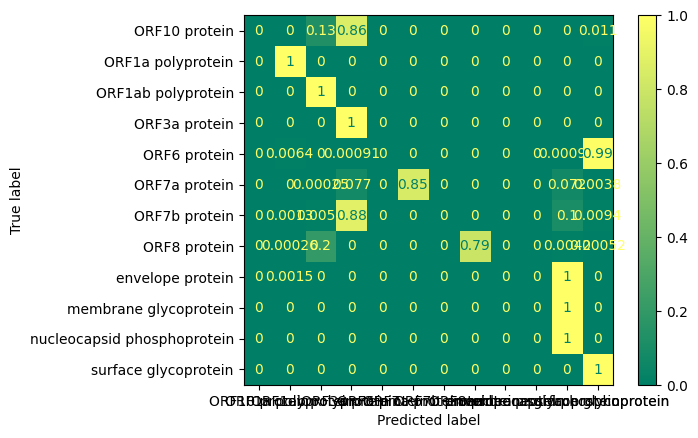

In [40]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

In [41]:
print('izvestaj za test skup')

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       0.00      0.00      0.00        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       1.00      1.00      1.00     78610
              ORF3a protein       0.94      1.00      0.97      4619
               ORF6 protein       0.00      0.00      0.00       274
              ORF7a protein       1.00      0.85      0.92       984
              ORF7b protein       0.00      0.00      0.00       186
               ORF8 protein       1.00      0.78      0.87       958
           envelope protein       0.00      0.00      0.00       164
      membrane glycoprotein       0.00      0.00      0.00      1271
nucleocapsid phosphoprotein       0.83      1.00      0.91      7276
       surface glycoprotein       0.99      1.00      0.99     19196

                   accuracy                           0.99    173972
          

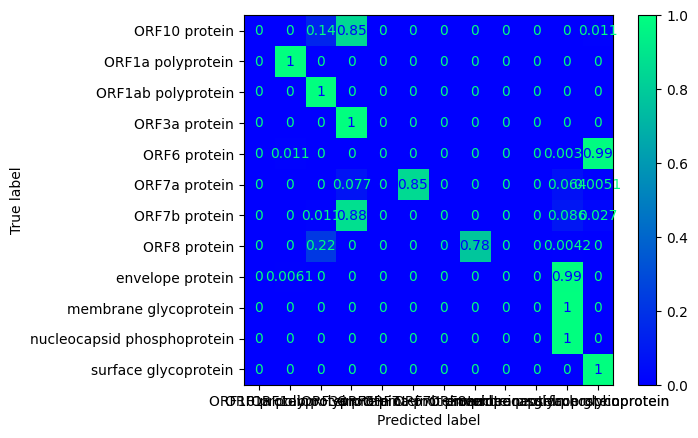

In [42]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()

In [102]:
params = [{'criterion': ['gini', 'entropy'],
            'max_depth': [4, 16, 32, 64],
            'min_samples_split': [128, 256],
            'min_samples_leaf': [32, 64],
            'random_state': [196883]},
          {'criterion': ['gini', 'entropy'],
            'random_state': [196883],
            'min_impurity_decrease': [0.01, 0.02, 0.03, 0.04],
            'ccp_alpha': [0.01, 0.02, 0.03, 0.04]}]

In [103]:
clf = GridSearchCV(DecisionTreeClassifier(), params, scoring='balanced_accuracy', n_jobs=-1, cv=5)
_ = clf.fit(X_train, y_train)

In [104]:
clf.best_score_

0.991189322460462

In [105]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 16,
 'min_samples_leaf': 32,
 'min_samples_split': 128,
 'random_state': 196883}

In [106]:
# print(X.columns.to_numpy())
# print(clf.best_estimator_.classes_)

# viz = dtreeviz(clf.best_estimator_,
#                x_data=X_train, y_data=y_train,
#                feature_names=X.columns.to_numpy(),
#                target_name='Tip proteina',
#                class_names=[clf.best_estimator_.classes_])

In [107]:
print('izvestaj za trening skup')

y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       0.95      1.00      0.97       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       1.00      1.00      1.00     18476
               ORF6 protein       1.00      0.99      0.99      1098
              ORF7a protein       1.00      0.99      1.00      3937
              ORF7b protein       0.99      0.98      0.99       743
               ORF8 protein       1.00      0.99      0.99      3831
           envelope protein       0.97      0.98      0.97       658
      membrane glycoprotein       1.00      1.00      1.00      5083
nucleocapsid phosphoprotein       1.00      1.00      1.00     29103
       surface glycoprotein       1.00      1.00      1.00     76782

                   accuracy                           1.00    695886
       

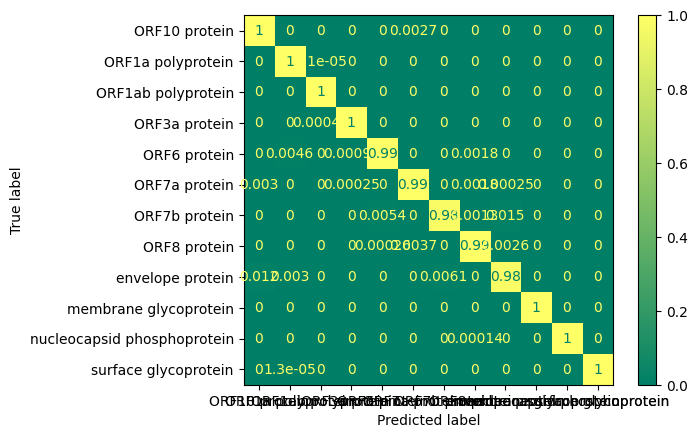

In [108]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

In [109]:
print('izvestaj za test skup')

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       0.95      0.99      0.97        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       1.00      1.00      1.00     78610
              ORF3a protein       1.00      1.00      1.00      4619
               ORF6 protein       0.99      0.99      0.99       274
              ORF7a protein       0.99      1.00      1.00       984
              ORF7b protein       0.98      0.98      0.98       186
               ORF8 protein       1.00      0.99      0.99       958
           envelope protein       0.97      0.96      0.97       164
      membrane glycoprotein       1.00      1.00      1.00      1271
nucleocapsid phosphoprotein       1.00      1.00      1.00      7276
       surface glycoprotein       1.00      1.00      1.00     19196

                   accuracy                           1.00    173972
          

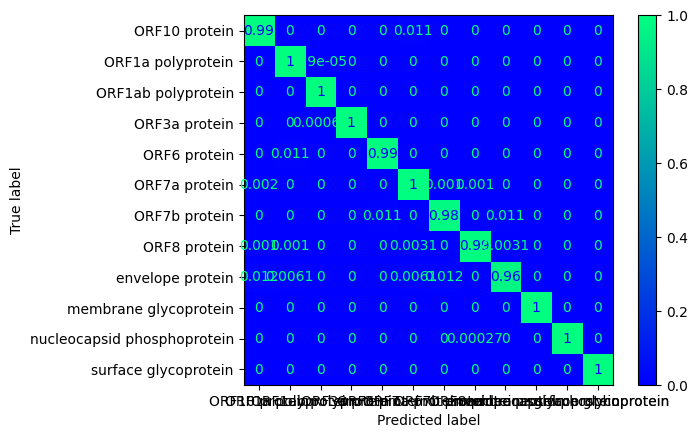

In [110]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()

In [94]:
params = [{'n_estimators': [64, 128, 256],
           'criterion': ['entropy'],
           'max_features': [0.4, 0.6],
           'max_samples': [0.4, 0.6],
           'n_jobs': [-1],
           'random_state': [196883]}]

In [95]:
clf = GridSearchCV(RandomForestClassifier(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train, y_train)

In [96]:
clf.best_score_

0.9999014273894076

In [97]:
clf.best_params_

{'criterion': 'entropy',
 'max_features': 0.4,
 'max_samples': 0.4,
 'n_estimators': 128,
 'n_jobs': -1,
 'random_state': 196883}

In [98]:
print('izvestaj za trening skup')

y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      1.00      1.00       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       1.00      1.00      1.00     18476
               ORF6 protein       1.00      1.00      1.00      1098
              ORF7a protein       1.00      1.00      1.00      3937
              ORF7b protein       1.00      1.00      1.00       743
               ORF8 protein       1.00      1.00      1.00      3831
           envelope protein       1.00      1.00      1.00       658
      membrane glycoprotein       1.00      1.00      1.00      5083
nucleocapsid phosphoprotein       1.00      1.00      1.00     29103
       surface glycoprotein       1.00      1.00      1.00     76782

                   accuracy                           1.00    695886
       

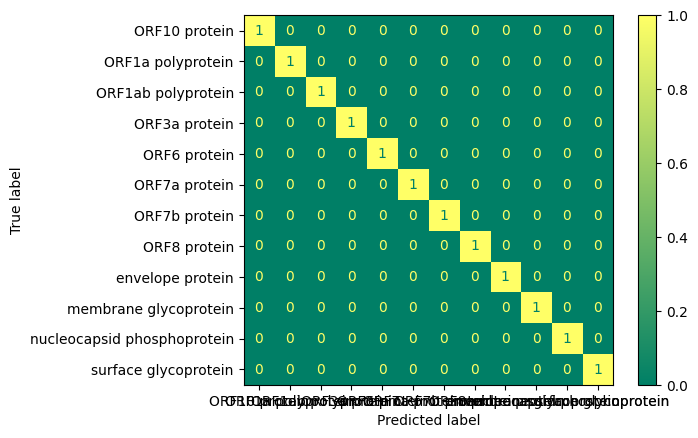

In [99]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

In [100]:
print('izvestaj za test skup')

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      1.00      1.00        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       1.00      1.00      1.00     78610
              ORF3a protein       1.00      1.00      1.00      4619
               ORF6 protein       1.00      1.00      1.00       274
              ORF7a protein       1.00      1.00      1.00       984
              ORF7b protein       1.00      1.00      1.00       186
               ORF8 protein       1.00      1.00      1.00       958
           envelope protein       1.00      1.00      1.00       164
      membrane glycoprotein       1.00      1.00      1.00      1271
nucleocapsid phosphoprotein       1.00      1.00      1.00      7276
       surface glycoprotein       1.00      1.00      1.00     19196

                   accuracy                           1.00    173972
          

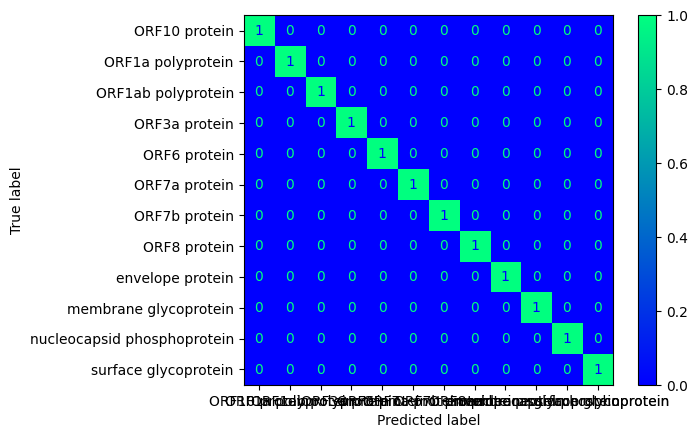

In [101]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()

In [86]:
params = [{'n_estimators': [32, 64, 128],
           'max_depth': [2, 4],
           'learning_rate': [0.01, 0.1, 0.2],
           'objective': ['reg:linear'],
           'nthread': [-1],
           'random_state': [196883]}]

In [87]:
clf = GridSearchCV(XGBClassifier(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train, enc.transform(y_train))

In [88]:
clf.best_score_

0.9997906559182297

In [89]:
clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 64,
 'nthread': -1,
 'objective': 'reg:linear',
 'random_state': 196883}

In [90]:
print('izvestaj za trening skup')

y_true, y_pred = y_train, enc.inverse_transform(clf.predict(X_train))
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      1.00      1.00       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       1.00      1.00      1.00     18476
               ORF6 protein       1.00      1.00      1.00      1098
              ORF7a protein       1.00      1.00      1.00      3937
              ORF7b protein       1.00      1.00      1.00       743
               ORF8 protein       1.00      1.00      1.00      3831
           envelope protein       1.00      1.00      1.00       658
      membrane glycoprotein       1.00      1.00      1.00      5083
nucleocapsid phosphoprotein       1.00      1.00      1.00     29103
       surface glycoprotein       1.00      1.00      1.00     76782

                   accuracy                           1.00    695886
       

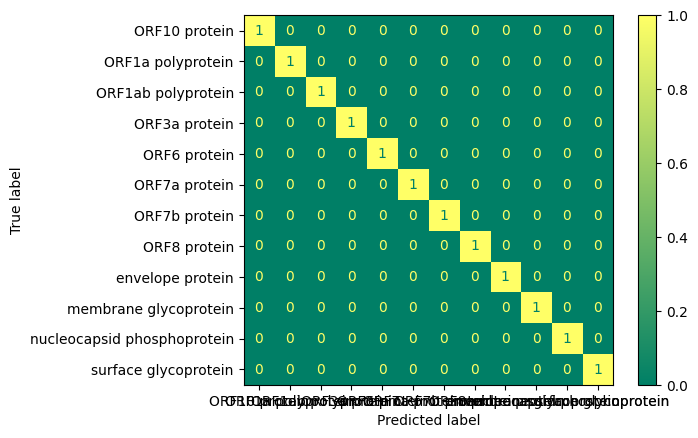

In [91]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

In [92]:
print('izvestaj za test skup')

y_true, y_pred = y_test, enc.inverse_transform(clf.predict(X_test))
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      1.00      1.00        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       1.00      1.00      1.00     78610
              ORF3a protein       1.00      1.00      1.00      4619
               ORF6 protein       1.00      1.00      1.00       274
              ORF7a protein       1.00      1.00      1.00       984
              ORF7b protein       1.00      1.00      1.00       186
               ORF8 protein       1.00      1.00      1.00       958
           envelope protein       1.00      1.00      1.00       164
      membrane glycoprotein       1.00      1.00      1.00      1271
nucleocapsid phosphoprotein       1.00      1.00      1.00      7276
       surface glycoprotein       1.00      1.00      1.00     19196

                   accuracy                           1.00    173972
          

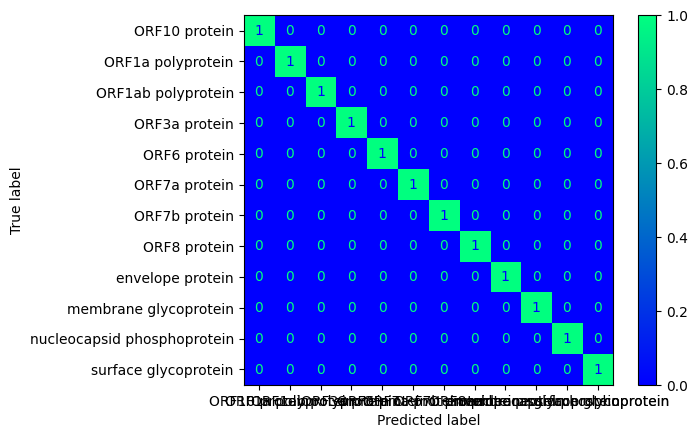

In [93]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()

In [78]:
params = [{'penalty': ['l2'],
           'dual': ['auto'],
           'C': [0.1, 1, 10, 100],
           'fit_intercept': [True],
           'intercept_scaling': [0.001, 0.1, 1, 10],
           'class_weight': ['balanced'],
           'max_iter': [2147483647],
           'random_state': [196883]}]

In [79]:
clf = GridSearchCV(LinearSVC(), params, scoring='balanced_accuracy', n_jobs=-1, cv=5)
_ = clf.fit(X_train, y_train)

In [80]:
clf.best_score_

0.9996634294551253

In [81]:
clf.best_params_

{'C': 10,
 'class_weight': 'balanced',
 'dual': 'auto',
 'fit_intercept': True,
 'intercept_scaling': 0.001,
 'max_iter': 2147483647,
 'penalty': 'l2',
 'random_state': 196883}

In [82]:
print('izvestaj za trening skup')

y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za trening skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      1.00      1.00       364
          ORF1a polyprotein       1.00      1.00      1.00    241372
         ORF1ab polyprotein       1.00      1.00      1.00    314439
              ORF3a protein       1.00      1.00      1.00     18476
               ORF6 protein       1.00      1.00      1.00      1098
              ORF7a protein       1.00      1.00      1.00      3937
              ORF7b protein       1.00      1.00      1.00       743
               ORF8 protein       1.00      1.00      1.00      3831
           envelope protein       1.00      1.00      1.00       658
      membrane glycoprotein       1.00      1.00      1.00      5083
nucleocapsid phosphoprotein       1.00      1.00      1.00     29103
       surface glycoprotein       1.00      1.00      1.00     76782

                   accuracy                           1.00    695886
       

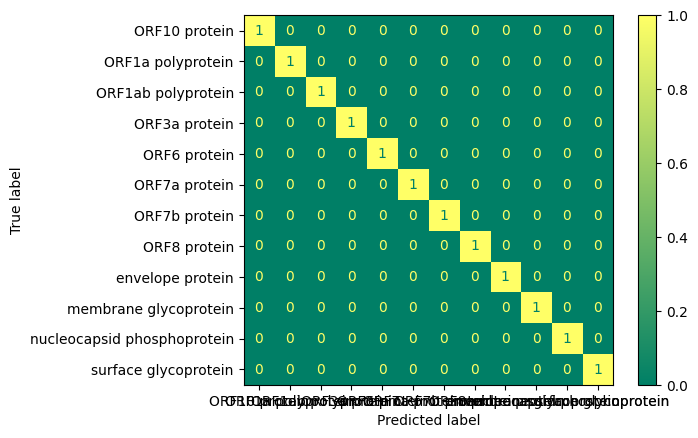

In [83]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='summer')
plt.show()

In [84]:
print('izvestaj za test skup')

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, zero_division=0.0))

izvestaj za test skup
                             precision    recall  f1-score   support

              ORF10 protein       1.00      0.99      0.99        91
          ORF1a polyprotein       1.00      1.00      1.00     60343
         ORF1ab polyprotein       1.00      1.00      1.00     78610
              ORF3a protein       1.00      1.00      1.00      4619
               ORF6 protein       1.00      1.00      1.00       274
              ORF7a protein       1.00      1.00      1.00       984
              ORF7b protein       1.00      1.00      1.00       186
               ORF8 protein       1.00      1.00      1.00       958
           envelope protein       1.00      1.00      1.00       164
      membrane glycoprotein       1.00      1.00      1.00      1271
nucleocapsid phosphoprotein       1.00      1.00      1.00      7276
       surface glycoprotein       1.00      1.00      1.00     19196

                   accuracy                           1.00    173972
          

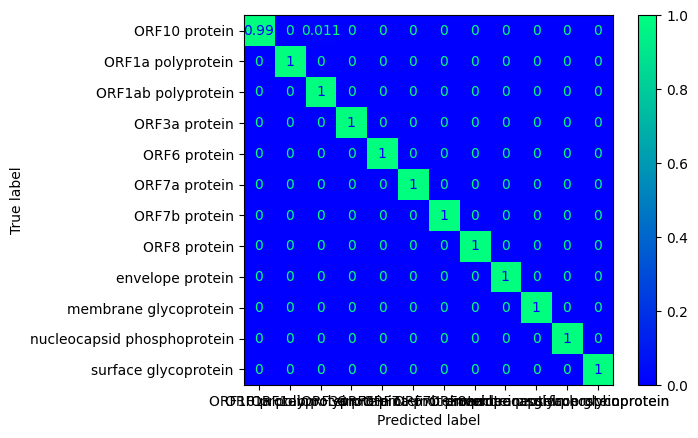

In [85]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=proteins.index)
fig = ConfusionMatrixDisplay(cm, display_labels=proteins.index)

fig.plot(cmap='winter')
plt.show()